# SPRINT 4

¿Cómo se relaciona el saldo medio de los clientes con la probabilidad de que suscriban un depósito a plazo, y qué estrategias podríamos implementar para utilizar esta información y aumentar la tasa de suscripción entre los clientes con saldos más bajos?

In [41]:
import pymysql
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

### CONEXIÓN

In [42]:
S4_df_BANK_marketing = pd.read_parquet('S4_df_BANK_marketing.parquet')
S4_df_BANK_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39188 entries, 0 to 39187
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39188 non-null  int64  
 1   age                  39188 non-null  float64
 2   job                  39188 non-null  object 
 3   marital              39188 non-null  object 
 4   education            39188 non-null  object 
 5   is_in_default        39188 non-null  int64  
 6   balance              39188 non-null  int64  
 7   housing              39188 non-null  int64  
 8   loan                 39188 non-null  int64  
 9   contact              39188 non-null  object 
 10  day                  39188 non-null  int64  
 11  month                39188 non-null  object 
 12  duration             39188 non-null  int64  
 13  campaign             39188 non-null  int64  
 14  pdays                39188 non-null  int64  
 15  previous             39188 non-null 

## EDA

In [43]:
print(S4_df_BANK_marketing.isnull().sum())
print(f"Los cantidad de duplicados es: {S4_df_BANK_marketing.duplicated().sum()}")


id                     0
age                    0
job                    0
marital                0
education              0
is_in_default          0
balance                0
housing                0
loan                   0
contact                0
day                    0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
poutcome               0
deposit                0
balance_normalizado    0
estado_balance         0
dtype: int64
Los cantidad de duplicados es: 0


Seleccionamos las columnas que útiles para el departamento de finanzas

In [44]:
df_f = S4_df_BANK_marketing[['id','age','job','marital','education','is_in_default','balance','housing','loan','deposit','balance_normalizado','estado_balance']]
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39188 entries, 0 to 39187
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39188 non-null  int64  
 1   age                  39188 non-null  float64
 2   job                  39188 non-null  object 
 3   marital              39188 non-null  object 
 4   education            39188 non-null  object 
 5   is_in_default        39188 non-null  int64  
 6   balance              39188 non-null  int64  
 7   housing              39188 non-null  int64  
 8   loan                 39188 non-null  int64  
 9   deposit              39188 non-null  int64  
 10  balance_normalizado  39188 non-null  float64
 11  estado_balance       39188 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 3.6+ MB


In [45]:
df_f.head()

,id,age,job,marital,education,is_in_default,balance,housing,loan,deposit,balance_normalizado,estado_balance
0,1,59.0,admin.,married,secondary,0,2343,1,0,1,0.260495,Saldo Alto
1,2,59.0,admin.,married,secondary,0,2343,1,0,1,0.260495,Saldo Alto
2,3,56.0,admin.,married,secondary,0,45,0,0,1,-0.455442,Saldo Bajo
3,4,41.0,technician,married,secondary,0,1270,1,0,1,-0.073796,Saldo Medio Alto
4,5,55.0,services,married,secondary,0,2476,1,0,1,0.301931,Saldo Alto


In [46]:
df_f.describe()

,id,age,is_in_default,balance,housing,loan,deposit,balance_normalizado
count,39188.000000,39188.000000,39188.000000,39188.000000,39188.000000,39188.000000,39188.000000,3.918800e+04
mean,21776.979330,41.228106,0.015438,1506.869271,0.472517,0.131112,0.471165,1.994480e-17
std,13954.569093,11.866142,0.123290,3209.820943,0.499250,0.337527,0.499174,1.000013e+00
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,-2.602630e+00
25%,9797.750000,32.000000,0.000000,121.000000,0.000000,0.000000,0.000000,-4.317646e-01
50%,19594.500000,39.000000,0.000000,549.000000,0.000000,0.000000,0.000000,-2.984221e-01
75%,35970.250000,49.000000,0.000000,1693.000000,1.000000,0.000000,1.000000,5.798863e-02
max,45767.000000,95.000000,1.000000,81204.000000,1.000000,1.000000,1.000000,2.482947e+01


Vemos la cantidad total de cada opción a analizar

In [47]:
df_f['deposit'] = df_f['deposit'].astype(int)

df_f['deposit'].value_counts()


C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\894670705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['deposit'] = df_f['deposit'].astype(int)


deposit
0    20724
1    18464
Name: count, dtype: int64

Ordenamos la categoria estado_balance

In [48]:
estado_balance_order = ['Saldo Muy Alto', 'Saldo Alto', 'Saldo Medio Alto', 'Saldo Medio', 'Saldo Bajo', 'Saldo Muy Bajo']
df_f['estado_balance'] = pd.Categorical(df_f['estado_balance'], categories=estado_balance_order, ordered=True)

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\4283965127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['estado_balance'] = pd.Categorical(df_f['estado_balance'], categories=estado_balance_order, ordered=True)


Observamos la cantidad de depósitos por categroia de balance

In [49]:
conteo = df_f.groupby('estado_balance')['deposit'].value_counts()
conteo

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\842469846.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df_f.groupby('estado_balance')['deposit'].value_counts()


estado_balance    deposit
Saldo Muy Alto    1          2107
                  0          1554
Saldo Alto        1          3564
                  0          2588
Saldo Medio Alto  0          4929
                  1          4859
Saldo Medio       0          5316
                  1          4494
Saldo Bajo        0          6329
                  1          3437
Saldo Muy Bajo    0             8
                  1             3
Name: count, dtype: int64

- Media del balance según si han contratado depósito

In [50]:
mean_balance = df_f.groupby('deposit')['balance'].mean()
mean_balance.round(2)

deposit
0    1250.31
1    1794.83
Name: balance, dtype: float64

#### ANALISIS DESCRIPTIVO

In [51]:
df_f.groupby('deposit')['balance'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
deposit,,,,,,,,
0,20724.0,1250.31,2871.32,-6847.0,62.75,410.0,1301.0,66653.0
1,18464.0,1794.83,3529.47,-3058.0,216.00,751.0,2152.0,81204.0


Los clientes que suscribieron un depósito a plazo tienden a tener saldos más altos en promedio que aquellos que no lo hicieron. Por ejemplo, el saldo promedio de los clientes que suscribieron es de 1,794.83, mientras que el saldo promedio de los que no suscribieron es de 1,250.31. Esto sugiere que el saldo medio de los clientes está relacionado con la probabilidad de que suscriban un depósito. Además, los percentiles muestran que, en cada nivel de saldo, los clientes que suscribieron un depósito tienen saldos más altos. Por ejemplo, la mediana del saldo para los suscriptores es 751.00, comparado con 410.00 para los no suscriptores.  

En este primer análisis se puede ver que los clientes con balances más altos son más propensos a suscribirse a depósitos a plazo.

- Tasa promedia de depositos contratados segun estado_balance

In [52]:
estado_balance_mean = df_f.groupby('estado_balance')['deposit'].mean()
estado_balance_mean_percent = (estado_balance_mean * 100).round(2)
estado_balance_mean_percent

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\3234176887.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estado_balance_mean = df_f.groupby('estado_balance')['deposit'].mean()


estado_balance
Saldo Muy Alto      57.55
Saldo Alto          57.93
Saldo Medio Alto    49.64
Saldo Medio         45.81
Saldo Bajo          35.19
Saldo Muy Bajo      27.27
Name: deposit, dtype: float64

Existe una clara correlación entre el saldo de los clientes y la probabilidad de que suscriban un depósito a plazo. Los clientes con saldos más altos tienen una mayor tasa de suscripción, mientras que los clientes con saldos bajos o muy bajos muestran una menor inclinación a suscribirse.

#### TESTS ESTADÍSTICOS

##### Test T para deposit con balance

In [53]:
from scipy.stats import ttest_ind

# Realizar un test t para comparar el saldo entre clientes que suscribieron y los que no
saldo_no_deposit = df_f[df_f['deposit'] == 0]['balance']
saldo_deposit = df_f[df_f['deposit'] == 1]['balance']
t_stat, p_value = ttest_ind(saldo_no_deposit, saldo_deposit)
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -16.823629508490622, P-value: 2.73395978705713e-63


La prueba t sugiere que hay una diferencia significativa en los saldos medios entre los clientes que suscribieron un depósito a plazo y los que no. Los clientes que suscribieron un depósito tienen saldos significativamente más altos en promedio.

El valor p es extremadamente bajo Esto indica que hay una diferencia estadísticamente significativa entre los saldos de los dos grupos de clientes. Por lo tanto este resultado respalda nuestra observación anterior de que el saldo medio está relacionado con la probabilidad de suscripción a un depósito. Los clientes con saldos más altos son más propensos a suscribirse a depósitos a plazo.

In [54]:
from scipy.stats import chi2_contingency

tabla_con = pd.crosstab(df_f['estado_balance'], df_f['deposit'])
chi2, p, dof, expected = chi2_contingency(tabla_con)
print(f"Chi2 Test p-value: {p}")

Chi2 Test p-value: 1.6441323507617388e-222


El resultado del test Chi-cuadrado sugiere que existe una relación estadísticamente significativa entre las categorías de saldo (estado_balance) y el estado de morosidad (is_in_default).

#### PRIMERAS VISUALIZACIONES

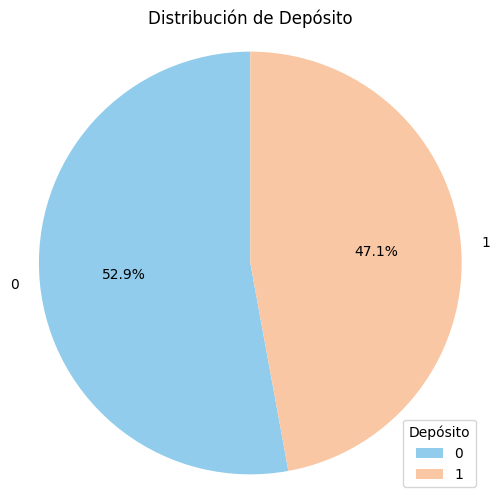

In [55]:
deposit_counts = df_f['deposit'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(deposit_counts, labels=deposit_counts.index, autopct='%1.1f%%', startangle=90, colors=['#91ccec', '#f9c7a4'])
plt.title('Distribución de Depósito')
plt.legend(deposit_counts.index, title="Depósito", loc="lower right")
plt.axis('equal')  
plt.show()

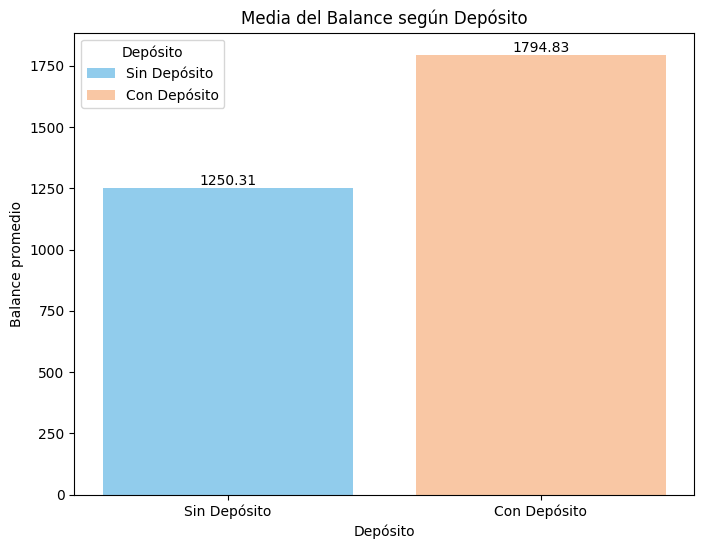

In [56]:
plt.figure(figsize=(8, 6))
bars = plt.bar(mean_balance.index, mean_balance, color=['#91ccec', '#f9c7a4'], label=['Sin Depósito', 'Con Depósito'])
# Añadir valores encima
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',ha='center', va='bottom', fontsize=10, color='black')


plt.title('Media del Balance según Depósito')
plt.xlabel('Depósito')
plt.ylabel('Balance promedio')
plt.xticks(range(len(mean_balance.index)), ['Sin Depósito', 'Con Depósito'], rotation=0)
plt.legend(title='Depósito', loc='best')

plt.show()

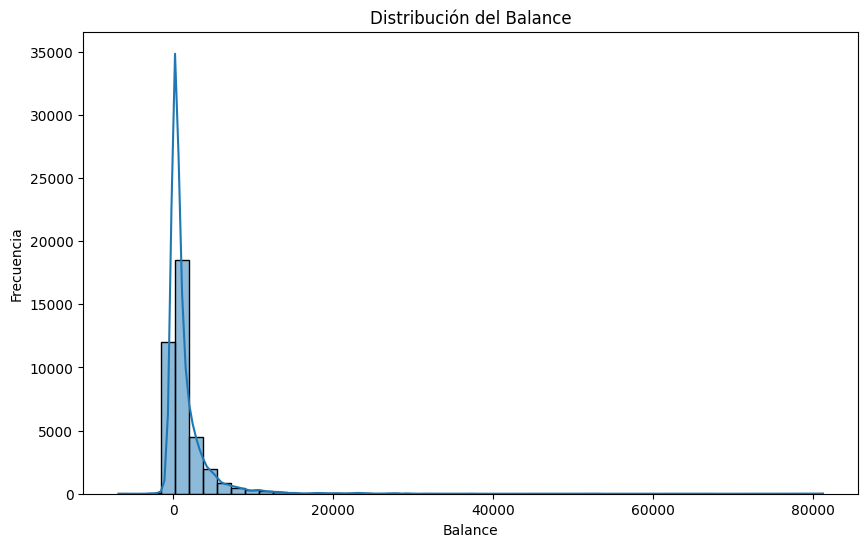

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(df_f['balance'], bins=50, kde=True)
plt.title('Distribución del Balance')
plt.xlabel('Balance')
plt.ylabel('Frecuencia')
plt.show()

##### Histograma de la Distribución de Saldos por Depósito

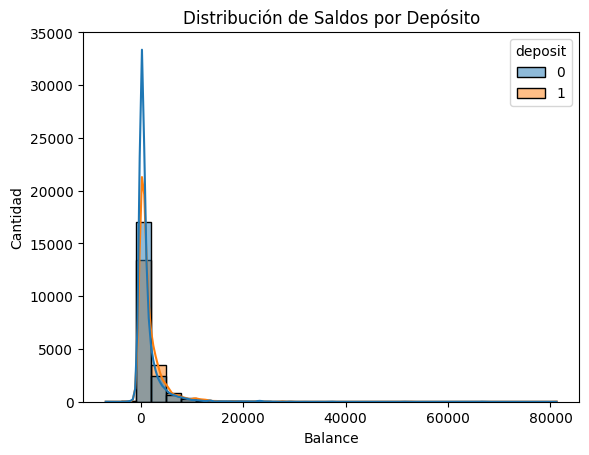

In [58]:
sns.histplot(data=df_f, x='balance', hue='deposit', kde=True, bins=30)
plt.title('Distribución de Saldos por Depósito')
plt.xlabel('Balance')
plt.ylabel('Cantidad')
plt.show()



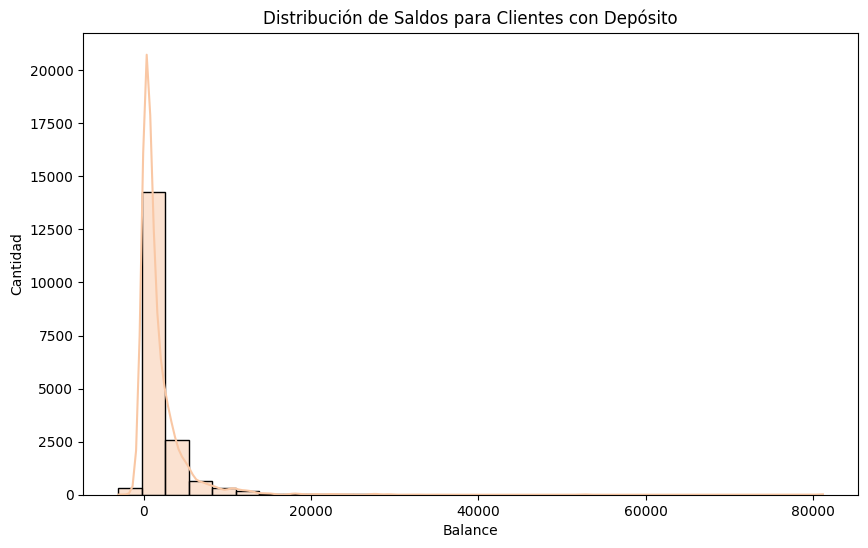

In [59]:
# Filtrar los datos para incluir solo clientes con depósito
df_deposito = df_f[df_f['deposit'] == 1]


plt.figure(figsize=(10, 6))
sns.histplot(data=df_deposito, x='balance', kde=True, bins=30, color='#f9c7a4')
plt.title('Distribución de Saldos para Clientes con Depósito')
plt.xlabel('Balance')
plt.ylabel('Cantidad')
plt.show()


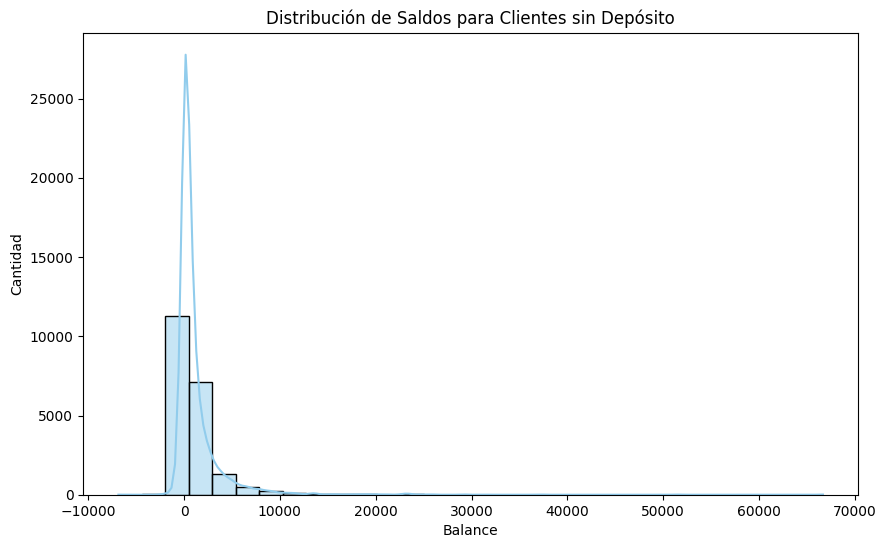

In [60]:
df_no_deposito = df_f[df_f['deposit'] == 0]


plt.figure(figsize=(10, 6))
sns.histplot(data=df_no_deposito, x='balance', kde=True, bins=30, color='#91ccec')
plt.title('Distribución de Saldos para Clientes sin Depósito')
plt.xlabel('Balance')
plt.ylabel('Cantidad')
plt.show()

##### Boxplot del Balance por Estado de Morosidad

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\2336537845.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='deposit', x='balance', data=df_f, palette='coolwarm', orient='h')


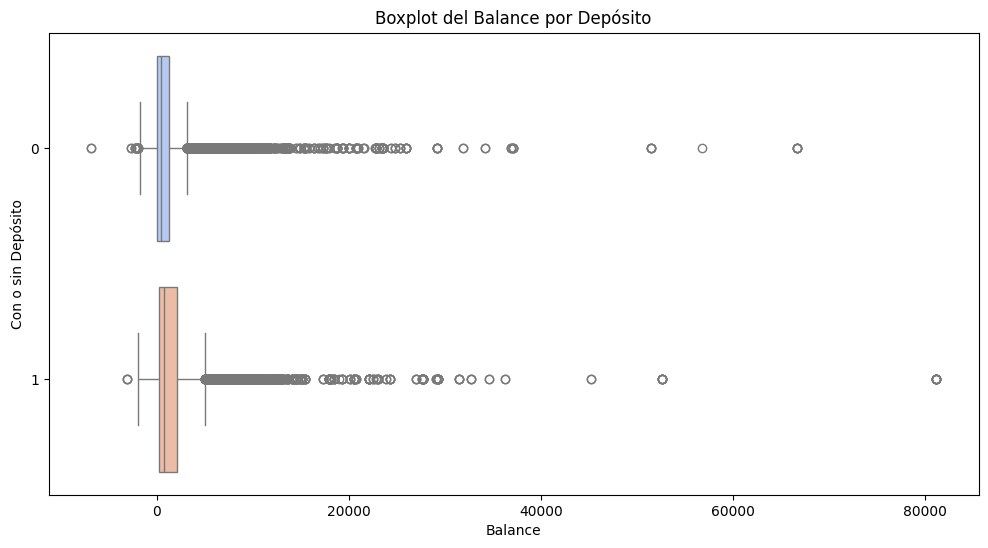

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='deposit', x='balance', data=df_f, palette='coolwarm', orient='h')
plt.title('Boxplot del Balance por Depósito')
plt.ylabel('Con o sin Depósito')
plt.xlabel('Balance')
plt.show()



##### Balances por Categoría de Saldo según Éxito de contratación Depósito

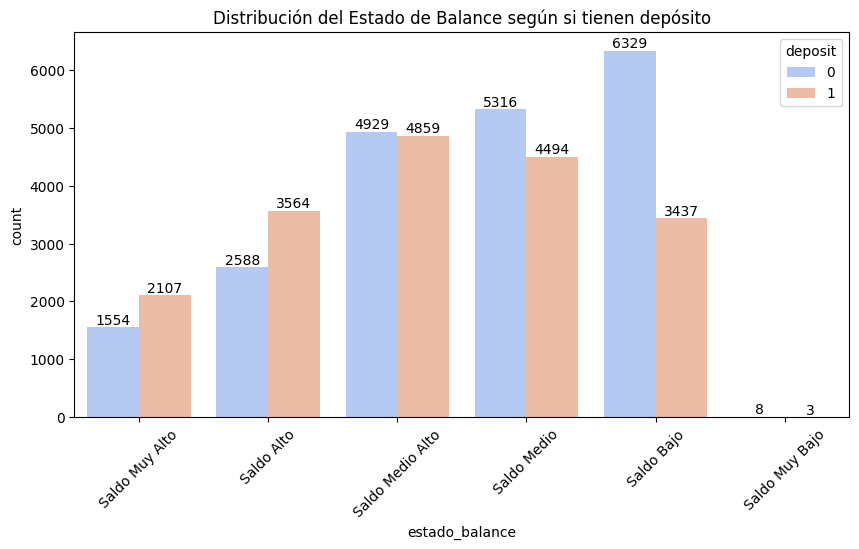

In [62]:
plt.figure(figsize=(10, 5))
num_deposit = sns.countplot(data=df_f, x='estado_balance', hue = 'deposit',palette='coolwarm')
for bar in num_deposit.containers: # número en las barras
    num_deposit.bar_label(bar)
plt.title('Distribución del Estado de Balance según si tienen depósito')
plt.xticks(rotation=45)
plt.show()


# ANALISIS

##### Gráfico de Cuartiles de Saldos y Éxito del Depósito

In [63]:
cuartiles, bin_edges = pd.qcut(df_f['balance'], 4, retbins=True, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Mostrar los puntos de corte
print("Puntos de corte de los cuartiles:")
for i in range(len(bin_edges) - 1):
    print(f"Cuartil {i+1}: de {bin_edges[i]:.2f} a {bin_edges[i+1]:.2f}")

Puntos de corte de los cuartiles:
Cuartil 1: de -6847.00 a 121.00
Cuartil 2: de 121.00 a 549.00
Cuartil 3: de 549.00 a 1693.00
Cuartil 4: de 1693.00 a 81204.00


- Creamos la categoria

In [64]:
df_f['balance_cuartiles'] = pd.qcut(df_f['balance'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
deposito_cuartiles = df_f.groupby('balance_cuartiles')['deposit'].mean() * 100
deposito_cuartiles.round(2)

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\2289582159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['balance_cuartiles'] = pd.qcut(df_f['balance'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\2289582159.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deposito_cuartiles = df_f.groupby('balance_cuartiles')['deposit'].mean() * 100


balance_cuartiles
Q1    35.27
Q2    45.74
Q3    49.71
Q4    57.75
Name: deposit, dtype: float64

- Tabla para mostrar los resultados totales

In [65]:
crosstab_cuartiles = pd.crosstab(df_f['balance_cuartiles'], df_f['deposit'])
#Calculo del porcentaje
crosstab_cuartiles['%_0'] = (crosstab_cuartiles[0] / (crosstab_cuartiles[0] + crosstab_cuartiles[1]) * 100).round(2)
crosstab_cuartiles['%_1'] = (crosstab_cuartiles[1] / (crosstab_cuartiles[0] + crosstab_cuartiles[1]) * 100).round(2)
print(crosstab_cuartiles)

deposit               0     1    %_0    %_1
balance_cuartiles                          
Q1                 6342  3456  64.73  35.27
Q2                 5322  4486  54.26  45.74
Q3                 4922  4865  50.29  49.71
Q4                 4138  5657  42.25  57.75


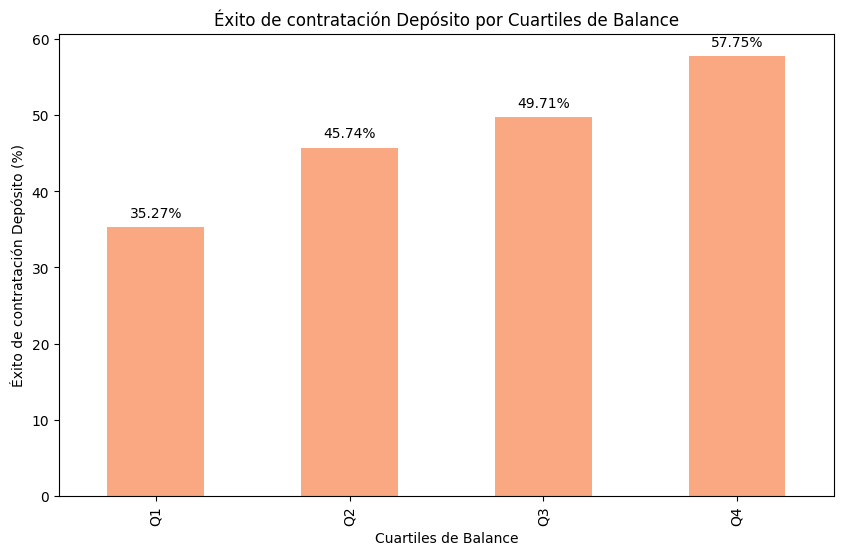

In [66]:
plt.figure(figsize=(10, 6))
ax = deposito_cuartiles.plot(kind='bar', color='#f9a881')
plt.xlabel('Cuartiles de Balance')
plt.ylabel('Éxito de contratación Depósito (%)')
plt.title('Éxito de contratación Depósito por Cuartiles de Balance')

# Añadir porcentajes encima de las columnas
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

##### Éxito del depósito por Categoría de Saldo

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\888137412.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  riesgo_categoria_balance = df_f.groupby('estado_balance')['deposit'].mean().reset_index()
C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\888137412.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=riesgo_categoria_balance, x='estado_balance', y='deposit', palette='coolwarm')


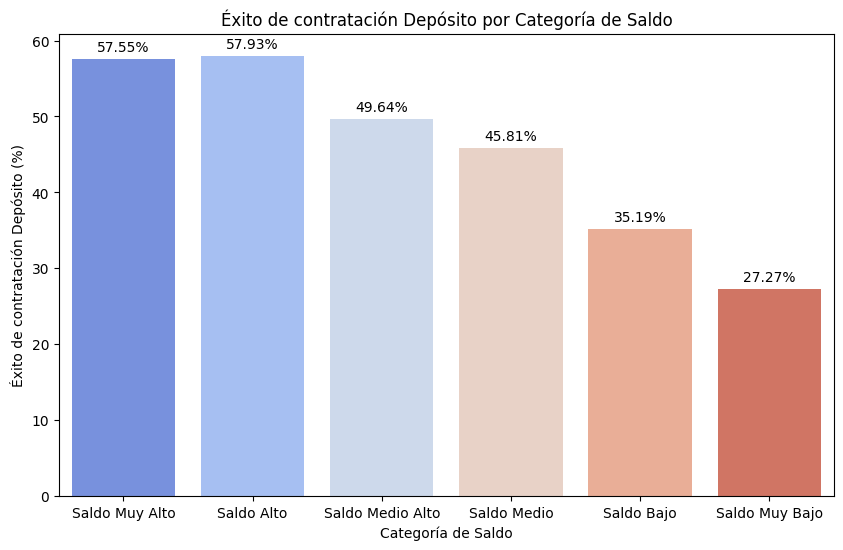

In [67]:
riesgo_categoria_balance = df_f.groupby('estado_balance')['deposit'].mean().reset_index()

# Convertir la éxito de depósito a porcentaje
riesgo_categoria_balance['deposit'] = riesgo_categoria_balance['deposit'] * 100
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=riesgo_categoria_balance, x='estado_balance', y='deposit', palette='coolwarm')

# Añadir los porcentajes sobre las barras
for index, row in riesgo_categoria_balance.iterrows():
    barplot.text(index, row['deposit'] + 1, f"{row['deposit']:.2f}%", color='black', ha="center")

plt.title('Éxito de contratación Depósito por Categoría de Saldo')
plt.xlabel('Categoría de Saldo')
plt.ylabel('Éxito de contratación Depósito (%)')
plt.show()


- Tabla para mostrar los resultados totales

In [68]:
crosstab_estado_balance = pd.crosstab(df_f['estado_balance'], df_f['deposit'])
#Calculo del porcentaje
crosstab_estado_balance['%_0'] = (crosstab_estado_balance[0] / (crosstab_estado_balance[0] + crosstab_estado_balance[1]) * 100).round(2)
crosstab_estado_balance['%_1'] = (crosstab_estado_balance[1] / (crosstab_estado_balance[0] + crosstab_estado_balance[1]) * 100).round(2)
print(crosstab_estado_balance)


deposit              0     1    %_0    %_1
estado_balance                            
Saldo Muy Alto    1554  2107  42.45  57.55
Saldo Alto        2588  3564  42.07  57.93
Saldo Medio Alto  4929  4859  50.36  49.64
Saldo Medio       5316  4494  54.19  45.81
Saldo Bajo        6329  3437  64.81  35.19
Saldo Muy Bajo       8     3  72.73  27.27


##### CLUSTERING

C:\Users\Adam\AppData\Local\Temp\ipykernel_14880\504556356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['cluster'] = kmeans.fit_predict(df_f[['balance', 'deposit']])


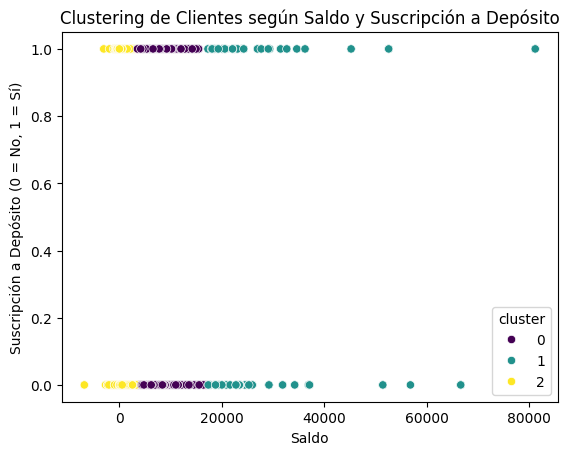

In [69]:
from sklearn.cluster import KMeans

# Realizar clustering para categorizar a los clientes según saldo y suscripción
kmeans = KMeans(n_clusters=3, random_state=42)
df_f['cluster'] = kmeans.fit_predict(df_f[['balance', 'deposit']])

# Visualización del clustering
sns.scatterplot(x='balance', y='deposit', hue='cluster', data=df_f, palette='viridis')
plt.title('Clustering de Clientes según Saldo y Suscripción a Depósito')
plt.xlabel('Saldo')
plt.ylabel('Suscripción a Depósito (0 = No, 1 = Sí)')
plt.show()


##### REGRESIÓN LOGÍSTICA

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Preparar los datos para la regresión logística
X = df_f[['balance_normalizado', 'estado_balance']]
y = df_f['deposit']
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.57      0.80      0.66      6213
           1       0.58      0.31      0.40      5544

    accuracy                           0.57     11757
   macro avg       0.57      0.56      0.53     11757
weighted avg       0.57      0.57      0.54     11757

[[4973 1240]
 [3823 1721]]


- Se observa que los porcentajes son un poco bajos y desestimamos una buena predicción con al regresión logística

##### RANDOM FOREST

In [85]:
from sklearn.ensemble import RandomForestClassifier

# Preparar los datos
X = df_f[['balance_normalizado', 'estado_balance']]
y = df_f['deposit']
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.78      0.76      6213
           1       0.74      0.68      0.71      5544

    accuracy                           0.74     11757
   macro avg       0.74      0.73      0.73     11757
weighted avg       0.74      0.74      0.74     11757

[[4863 1350]
 [1754 3790]]


Observamos con Random Forest una mayor precisión, de más del 70%, pero seguidamente queremos probar la predicción incluyendo más variables ara ver como se comporta y si se vuelve más fiable.

- Predicción con más variables

In [86]:
# Preparar los datos con variables adicionales
X = df_f[['balance', 'estado_balance', 'age', 'job', 'marital', 'education', 'is_in_default', 'housing', 'loan']]
y = df_f['deposit']
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6213
           1       0.95      0.95      0.95      5544

    accuracy                           0.95     11757
   macro avg       0.95      0.95      0.95     11757
weighted avg       0.95      0.95      0.95     11757

[[5952  261]
 [ 274 5270]]


- Confirmamos que este modelo es el más óptimo, ya que tiene una precisión del 95%, por lo tanto podemos decir que nuestro modelo predictivo es muy fiable.

#### IMPORTANCIA DE LAS CARACTERÍSTICAS

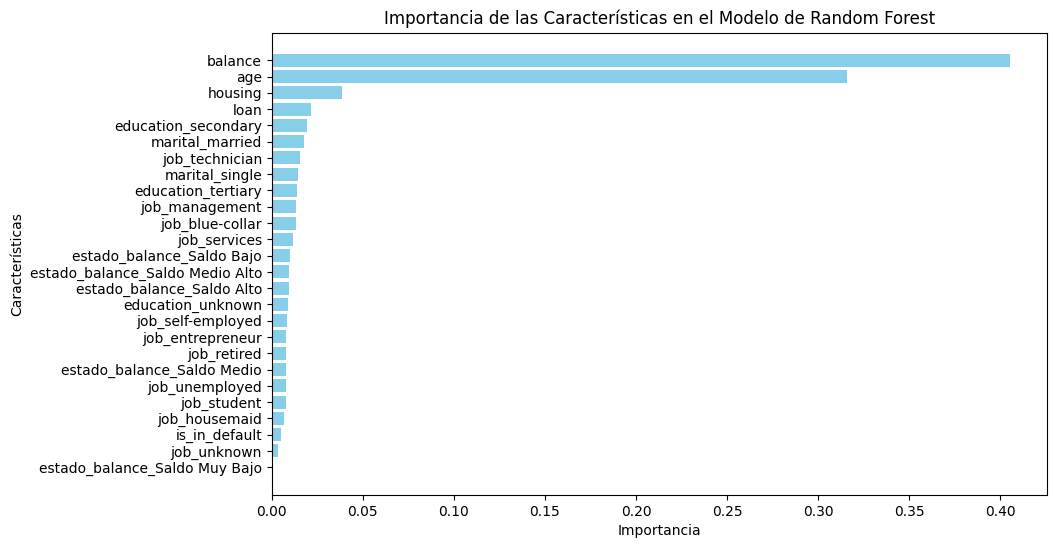

In [73]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características en el Modelo de Random Forest')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté en la parte superior
plt.show()


#### CURVA ROC Y AUC

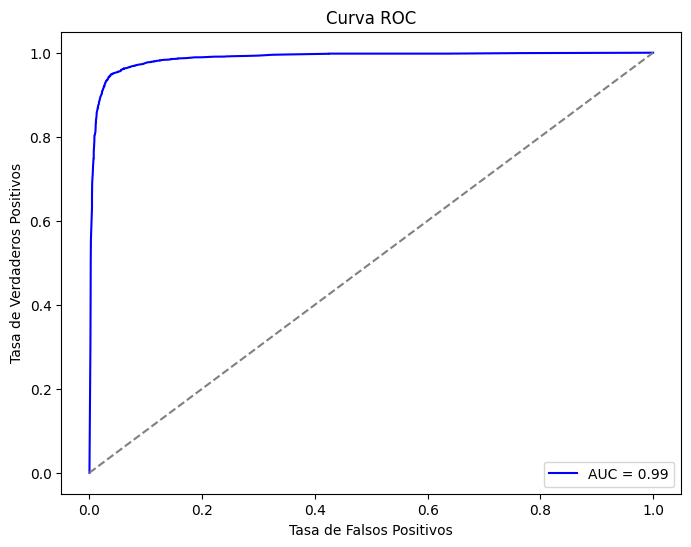

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades de predicción
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()




La Curva ROC y el AUC confirman que el modelo de Random Forest, optimizado con los mejores parámetros, es extremadamente fiable para predecir la probabilidad de que los clientes suscriban un depósito a plazo. Este alto rendimiento del modelo permitirá desarrollar estrategias de marketing y toma de decisiones basadas en datos con gran precisión.

#### MATRIZ DE CONFUSIÓN

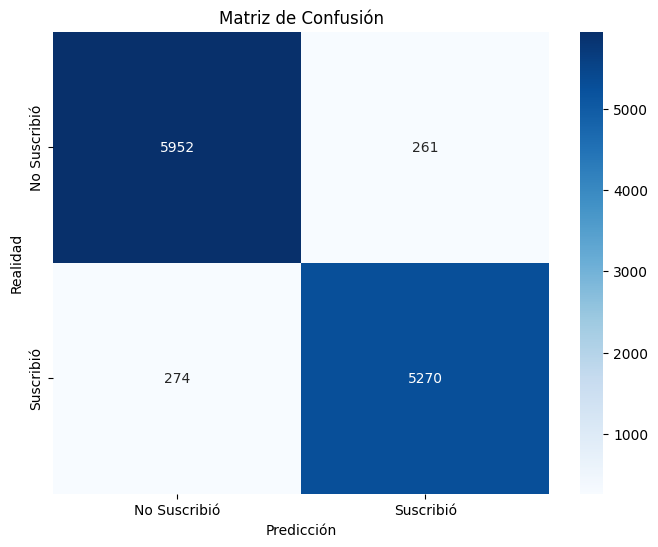

In [79]:
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Suscribió', 'Suscribió'], yticklabels=['No Suscribió', 'Suscribió'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()




Precisión: La alta cantidad de TN y TP indica que el modelo clasifica correctamente la mayoría de los casos.

Errores: Hay relativamente pocos FP y FN, lo que muestra un bajo nivel de error en las predicciones.

# CONCLUSIONES

-Los clientes con saldos más altos tienen más probabilidad de suscribir depósitos a plazo porque tienen mayor disponibilidad de capital, buscan maximizar rendimientos, cuentan con estabilidad financiera, y tienen mejor acceso a asesoría financiera. Esto les permite comprometer fondos a largo plazo sin afectar su liquidez diaria, haciéndolos más propensos a utilizar productos financieros como los depósitos a plazo.

-Un saldo más alto proporciona las condiciones necesarias para que los clientes consideren atractivos los depósitos a plazo, debido a su capacidad de inversión, motivaciones para maximizar rendimientos, estabilidad financiera y acceso a mejores recursos de asesoramiento. Esto explica por qué tienen una mayor probabilidad de suscribir estos productos.